In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
with_call = 'data/train_data/spec/1'
without_call = 'data/train_data/spec/0'

paths_with_call = [join(with_call, f) for f in listdir(with_call) if isfile(join(with_call, f))]
paths_without_call = [join(without_call, f) for f in listdir(without_call) if isfile(join(without_call, f))]

- (b) View Batch

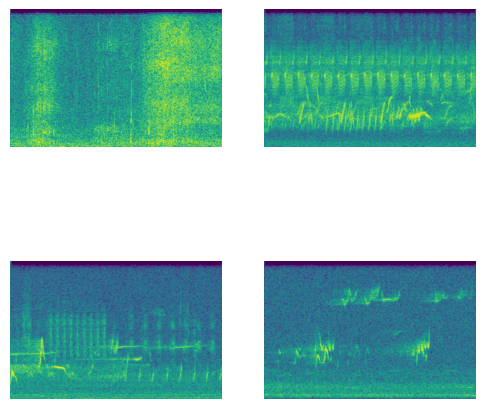

In [5]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_with_call[np.random.randint(len(paths_with_call))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_without_call[np.random.randint(len(paths_without_call))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_with_call[np.random.randint(len(paths_with_call))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_without_call[np.random.randint(len(paths_without_call))]));

Define Batch size

In [6]:
batch_size = 16

## B - <a name="generateurs"></a> Générateurs

- (c) Définir trois générateurs :
> - ```train_data_generator``` avec les paramètres de transformation de votre choix (on prendra un ```validation_split``` de 0.2 et un scaling de 1/255)
>
> - ```valid_data_generator``` avec un ```validation_split``` de 0.2 et un scaling de 1/255
>
> - ```test_data_generator``` avec un scaling de 1/255

In [7]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implémenter sous les noms ```training_data```, ```valid_data``` 
> - On choisira une taille cible de (224, 224) (pour le ```VGG16```), une classe binaire (avec ou sans masque), et des lots de données de taille 32 (pour train et valid) ou 1 (pour test).

In [8]:
training_data  = train_data_generator.flow_from_directory(directory = 'data/train_data/spec',
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = 'data/train_data/spec',
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

test_data  = test_data_generator.flow_from_directory(directory = 'data/train_data/spec',
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   batch_size = batch_size)


Found 2250 images belonging to 2 classes.
Found 561 images belonging to 2 classes.
Found 2811 images belonging to 2 classes.


In [9]:
import pandas as pd
import os

# Get all file paths and their corresponding labels
filepaths = [os.path.join(training_data.directory, fname) for fname in training_data.filenames]
labels = training_data.classes

# Convert to DataFrame
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

Oversample 

In [10]:
from collections import Counter

class_counts = Counter(training_data.classes)
print("Class Distribution:", class_counts)

max_samples = max(Counter(labels).values())  # Find max class count
df_oversampled = df.groupby('label', group_keys=False).apply(lambda x: x.sample(max_samples, replace=True))
df_oversampled.label = df_oversampled.label.astype(str)

print(df_oversampled['label'].value_counts())  # Check new distribution

Class Distribution: Counter({0: 1603, 1: 647})
0    1603
1    1603
Name: label, dtype: int64


In [11]:
training_data_os = data_generator.flow_from_dataframe(
    dataframe=df_oversampled,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=True
)

Found 3206 validated image filenames belonging to 2 classes.


# II - <a name="classif"></a> Classification

- (a) Importer le modèle ```VGG16``` et freezer ses couches.

- (b) Instancier un réseau de neurones (appelé ```model```), lui ajouter le modèle ```VGG16``` et ajouter les couches denses de votre choix.

- (c) Compiler le modèle avec une métrique appropriée.

- (d) Entraîner le modèle avec les paramètres de votre choix. On pourra également définir des callbacks.

- (e) Evaluer le modèle sur les données de test avec la méthode ```evaluate```.

In [12]:
# Modèle VGG16
#base_model = VGG16(weights='imagenet', include_top=False)
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches du VGG16
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\dgnhk\AppData\Local\Temp\ipykernel_13704\2462421750.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)


In [13]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience=3,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min',
                                         min_lr = 1e-10)

In [14]:
optimizer = Adam(learning_rate=0.0001) 

In [15]:
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
history = model.fit(training_data, validation_data=validation_data, epochs=25, callbacks=[early_stopping,lr_plateau])

Epoch 1/25


c:\Users\dgnhk\anaconda3\envs\yevhenii\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.5458 - loss: 0.6873 - val_accuracy: 0.7130 - val_loss: 0.6078 - learning_rate: 1.0000e-04
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.7217 - loss: 0.5834 - val_accuracy: 0.7130 - val_loss: 0.5778 - learning_rate: 1.0000e-04
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.7093 - loss: 0.5717 - val_accuracy: 0.7754 - val_loss: 0.5426 - learning_rate: 1.0000e-04
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.7410 - loss: 0.5412 - val_accuracy: 0.7897 - val_loss: 0.5139 - learning_rate: 1.0000e-04
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.7616 - loss: 0.5207 - val_accuracy: 0.8021 - val_loss: 0.4939 - learning_rate: 1.0000e-04
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.7683 - loss: 0.5129 - val_accuracy: 0.8021 - val_loss: 0.4886 - learning_rate: 1.0000e-04
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - 

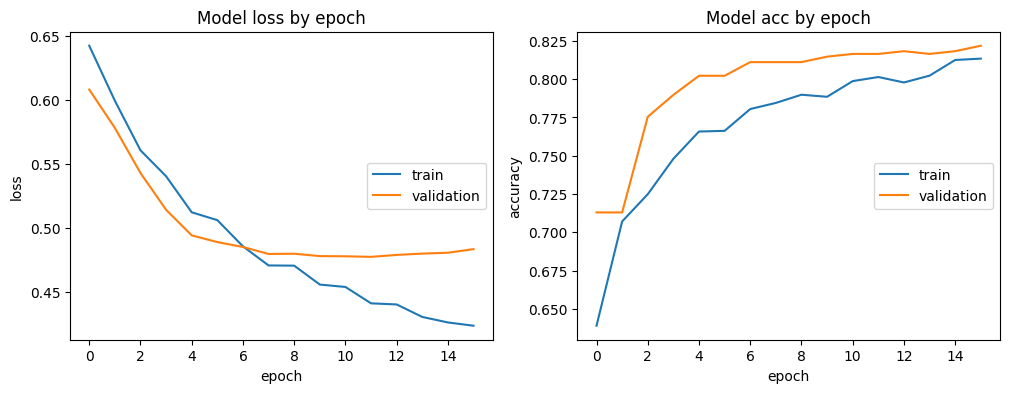

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [22]:
#model.save('my_model_epochs20.h5')

Calculate Average Precision

In [19]:
# Get true labels
y_true = test_data.classes  # Ground truth labels

# Get predicted probabilities
y_pred = model.predict(test_data)  # Softmax scores or probability values


176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step


In [20]:
ap_score = average_precision_score(y_true, y_pred)
ap_score

0.2932290446294046

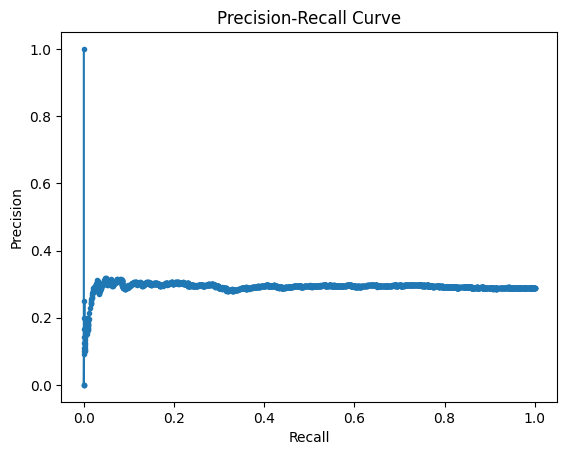

In [21]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Only for binary classification (adjust for multi-class)
precision, recall, _ = precision_recall_curve(y_true, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()